In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

In [3]:
df = pd.read_csv('./dataset/수홍velocity.csv')

In [4]:
df=df[df['SourceX'] != 0]
df=df[df['SourceY'] != 0]
df=df[df['TargetX'] != 0]
df=df[df['TargetY'] != 0]
df=df[df['Traffic'] != 0]

df['X'] = (df['SourceX'] + df['TargetX'])/2
df['Y'] = (df['SourceY'] + df['TargetY'])/2

max(df['X']), min(df['X']), max(df['Y']), min(df['Y']) , max(df['X'])- min(df['X']), max(df['Y'])-min(df['Y'])
df['X']=minmax_scale(df['X'], feature_range=(0, 1))
df['Y']=minmax_scale(df['Y'], feature_range=(0, 1))
df['XY']=(df['SourceX']-df['TargetX'])**2+(df['SourceY']-df['TargetY'])**2

df=df.sort_values(by=['XY'], axis=0)
df=df.drop_duplicates( ['Road_Name','Lanes','Road_Rank','Multi_Link','Connect','Traffic','OnlyBus' ] ,keep='last')

df=df.reset_index(drop=True)
features = df[['Lanes','Road_Rank','Multi_Link','Connect','OnlyBus','X','Y']]
features['Road_Rank']=features['Road_Rank'].apply(lambda x : str(x))
features['Connect']=features['Connect'].apply(lambda x : str(x))
features['OnlyBus']=features['OnlyBus'].apply(lambda x : str(x))
survival = df['Traffic']

<ipython-input-4-fc1b2bc36ed1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Road_Rank']=features['Road_Rank'].apply(lambda x : str(x))
<ipython-input-4-fc1b2bc36ed1>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Connect']=features['Connect'].apply(lambda x : str(x))
<ipython-input-4-fc1b2bc36ed1>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [5]:
train_X, test_X, train_Y, test_Y = train_test_split(features, survival,test_size=0.2)

In [6]:
train_df=pd.concat([train_X, train_Y], axis=1)
train_df=train_df.reset_index(drop=True)

test_df=pd.concat([test_X, test_Y], axis=1)
test_df=test_df.reset_index(drop=True)

len_train_df = len(train_df)
len_test_df = len(test_df)
len_train_df

1125

In [7]:
corrmat = train_df.corr()
top_corr_features = corrmat.index[abs(corrmat["Traffic"])>=0]
top_corr_features

Index(['Lanes', 'Multi_Link', 'X', 'Y', 'Traffic'], dtype='object')

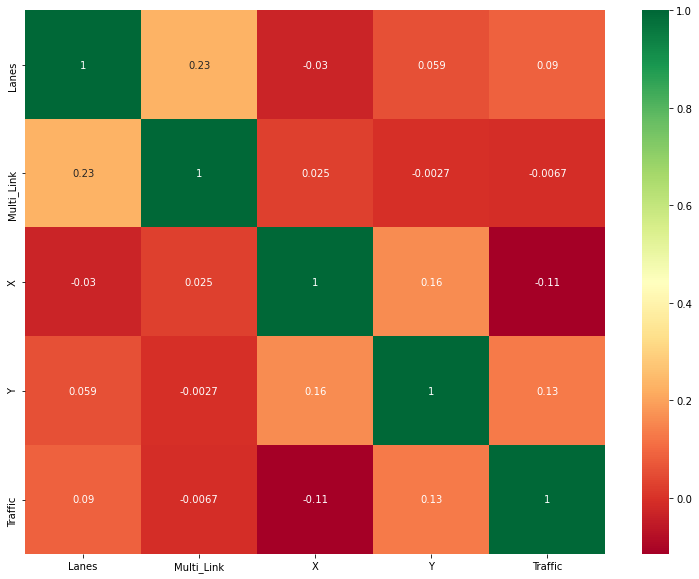

In [12]:
# heatmap
plt.figure(figsize=(13,10))
g = sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [27]:
# split y_label
train_y_label = train_df['Traffic'] 	# target 값을 미리 분리하였음.
train_df.drop(['Traffic'], axis=1, inplace=True)

In [28]:
# concat train & test
boston_df = pd.concat((train_df, test_df), axis=0)
boston_df_index = boston_df.index

print('Length of Boston Dataset : ',len(boston_df))

Length of Boston Dataset :  1407


In [29]:
# check null 
check_null = boston_df.isna().sum() / len(boston_df)

# columns of null ratio >= 0.5
check_null[check_null >= 0.5]

Traffic    0.799574
dtype: float64

In [30]:
# remove columns of null ratio >= 0.5
remove_cols = check_null[check_null >= 0.5].keys()
boston_df = boston_df.drop(remove_cols, axis=1)

boston_df.head()

,Lanes,Road_Rank,Multi_Link,Connect,OnlyBus,X,Y
0,3,107,0,0,0,0.435018,0.641403
1,1,107,0,0,0,0.532867,0.532444
2,5,104,0,104,1,0.648546,0.699897
3,4,103,0,0,1,0.974197,0.730332
4,1,107,0,0,0,0.122311,0.414221


In [31]:
# split object & numeric
boston_obj_df = boston_df.select_dtypes(include='object')	# 카테고리형
boston_num_df = boston_df.select_dtypes(exclude='object')	# 수치형

In [32]:
print('Object type columns:\n',boston_obj_df.columns)
print('---------------------------------------------------------------------------------')
print('Numeric type columns:\n',boston_num_df.columns)

Object type columns:
 Index(['Road_Rank', 'Connect', 'OnlyBus'], dtype='object')
---------------------------------------------------------------------------------
Numeric type columns:
 Index(['Lanes', 'Multi_Link', 'X', 'Y'], dtype='object')


In [33]:
boston_dummy_df = pd.get_dummies(boston_obj_df, drop_first=True)
boston_dummy_df.index = boston_df_index
boston_dummy_df.head()

,Road_Rank_102,Road_Rank_103,Road_Rank_104,Road_Rank_105,Road_Rank_106,Road_Rank_107,Connect_101,Connect_102,Connect_103,Connect_104,Connect_105,Connect_107,OnlyBus_1
0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,1
3,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,0,0


In [39]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(boston_num_df)
boston_num_df_ = imputer.transform(boston_num_df)

In [40]:
boston_num_df = pd.DataFrame(boston_num_df_, columns=boston_num_df.columns, index=boston_df_index)
boston_num_df.head()

,Lanes,Multi_Link,X,Y
0,3.0,0.0,0.435018,0.641403
1,1.0,0.0,0.532867,0.532444
2,5.0,0.0,0.648546,0.699897
3,4.0,0.0,0.974197,0.730332
4,1.0,0.0,0.122311,0.414221


In [50]:
boston_df = pd.concat([boston_dummy_df, boston_num_df], axis=1)
boston_df.head()
boston_df

,Road_Rank_102,Road_Rank_103,Road_Rank_104,Road_Rank_105,Road_Rank_106,Road_Rank_107,Connect_101,Connect_102,Connect_103,Connect_104,Connect_105,Connect_107,OnlyBus_1,Lanes,Multi_Link,X,Y
0,0,0,0,0,0,1,0,0,0,0,0,0,0,3.0,0.0,0.435018,0.641403
1,0,0,0,0,0,1,0,0,0,0,0,0,0,1.0,0.0,0.532867,0.532444
2,0,0,1,0,0,0,0,0,0,1,0,0,1,5.0,0.0,0.648546,0.699897
3,0,1,0,0,0,0,0,0,0,0,0,0,1,4.0,0.0,0.974197,0.730332
4,0,0,0,0,0,1,0,0,0,0,0,0,0,1.0,0.0,0.122311,0.414221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0,0,0,0,0,1,0,0,0,0,0,0,1,4.0,0.0,0.220020,0.545405
278,0,0,0,0,0,1,0,0,0,0,0,0,0,4.0,0.0,0.458459,0.530033
279,0,0,1,0,0,0,0,0,0,0,0,0,0,5.0,0.0,0.319813,0.985535
280,0,0,0,0,0,1,0,0,0,0,0,0,1,1.0,0.0,0.827172,0.789690


In [51]:
train_df = boston_df[:len_train_df]
test_df = boston_df[len_train_df:]

train_df['Traffic'] = train_y_label

print('train set length: ',len(train_df))
print('test set length: ',len(test_df))

train set length:  1125
test set length:  282


<ipython-input-51-60dd816e5639>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Traffic'] = train_y_label


In [52]:
from sklearn.model_selection import train_test_split

X_train = train_df.drop(['Traffic'], axis=1)
y_train = train_df['Traffic']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_test = test_df
test_id_idx = test_df.index

In [53]:
print('X_train : ',len(X_train))
print('X_val : ',len(X_val))
print('X_test :',len(X_test))

X_train :  900
X_val :  225
X_test : 282


In [54]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(550,700,50),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'colsample_bylevel': 0.7, 'colsample_bytree': 1, 'max_depth': 4, 'n_estimators': 550}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=550, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred_train = grid_search.predict(X_train)
pred_val = grid_search.predict(X_val)

print('train mae score: ', mean_absolute_error(y_train, pred_train))
print('val mae score:', mean_absolute_error(y_val, pred_val))

train mae score:  137.39973652733696
val mae score: 2759.4523906792533


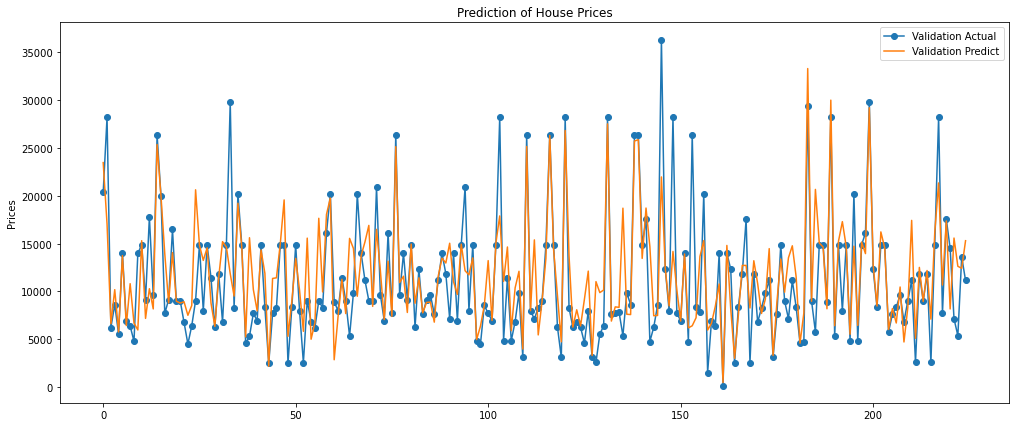

In [56]:
plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_val)), y_val,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '-', label='Validation Predict')
plt.title('Prediction of House Prices')
plt.ylabel('Prices')
plt.legend()

In [57]:
#test_y_pred = grid_search.predict(X_test)

In [58]:
#id_pred_df = pd.DataFrame()
#id_pred_df['Id'] = test_id_idx
#id_pred_df['SalePrice'] = test_y_pred

In [59]:
#id_pred_df.to_csv('./dataset/submission.csv', index=False)

In [62]:
import joblib
#save model
joblib.dump(model, './model/JDH') 

#load saved model
#xgb = joblib.load(filename)

['JDH']